1	


-1	


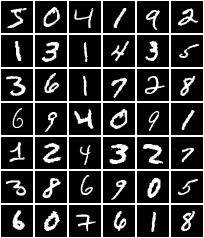

In [7]:
require 'image'
require 'torch'
require 'nn'
require 'optim'
require 'math'
mnist_x = torch.load('train_32x32.t7', 'ascii').data:double()/255
mnist_x = 2*(mnist_x - .5)
-- mnist_x = mnist_x - mnist_x:mean()
-- mnist_x = mnist_x / mnist_x:std()
--mnist_x = mnist_x / mnist_x:max()
print(mnist_x:max())
print(mnist_x:min())
itorch.image(mnist_x[{{1,42},{},{},{}}])
print(mnist_x:size())
dataSize = mnist_x:size(1)
dimSize = mnist_x:size(2) * mnist_x:size(3) * mnist_x:size(4)

In [8]:
n_hidded = 128
-- Generator
model_g = nn.Sequential()
model_g:add(nn.Linear(100, n_hidded))
--model_g:add(nn.BatchNormalization(128))
model_g:add(nn.LeakyReLU(0.01))
model_g:add(nn.Linear(n_hidded, 32*32))
--model_g:add(nn.BatchNormalization(32*32))
model_g:add(nn.Tanh())

In [9]:
-- Discriminator
model_d = nn.Sequential()
model_d:add(nn.Linear(32*32, n_hidded))
--model_d:add(nn.BatchNormalization(128))
model_d:add(nn.LeakyReLU(0.01))
model_d:add(nn.Linear(n_hidded, 2))

In [10]:
criterion = nn.CrossEntropyCriterion()
batchSize = 32
batchSizeHalf = batchSize / 2
batchData = torch.Tensor(batchSize, dimSize)

target_d = torch.Tensor(batchSize)
target_g = torch.Tensor(batchSizeHalf)

nBatches = math.floor(dataSize / batchSizeHalf)

optimMethod = optim.adagrad

optimState_g = {learningRate = 0.1}
optimState_d = {learningRate = 0.1}
maxEpoch = 10
dParams, dGradParams = model_d:getParameters()
gParams, gGradParams = model_g:getParameters()


In [11]:
function get_real_batch(batchData, batchId, shuffle, batchSize)
	for i = 1, batchSize do
		local id = shuffle[ (batchId - 1) * batchSize + i ]
		batchData[i]:copy(mnist_x[{{id},{},{},{}}]:reshape(dimSize))
	end
end

function get_fake_batch(randomData)
    return model_g:forward(randomdata)
end

Epoch 1 out of 10 done !!!	


0.9999978546623	
-0.99999999979048	


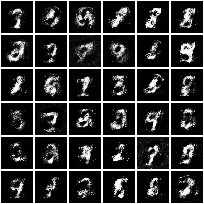

Epoch 2 out of 10 done !!!	

0.99995714497969	
-0.99999999971647	


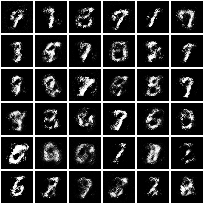

Epoch 3 out of 10 done !!!	


0.99999986977341	
-1	


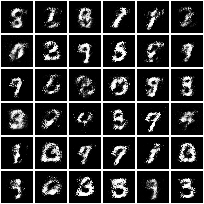

Epoch 4 out of 10 done !!!	


0.99999484067963	


-0.99999999999994	


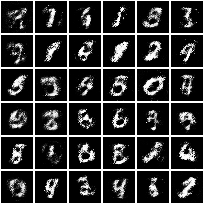

Epoch 5 out of 10 done !!!	


0.99998699189012	
-0.9999999999999	


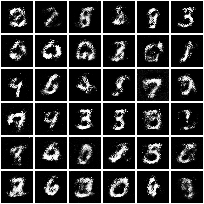

Epoch 6 out of 10 done !!!	


0.9999998455681	
-1	


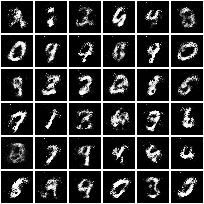

Epoch 7 out of 10 done !!!	


0.99999999966965	
-1	


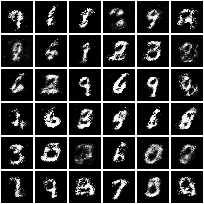

Epoch 8 out of 10 done !!!	


0.99999683375728	
-0.99999999998823	


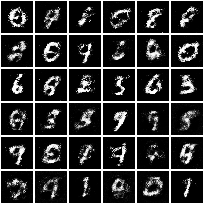

Epoch 9 out of 10 done !!!	
0.99999999820592	
-1	


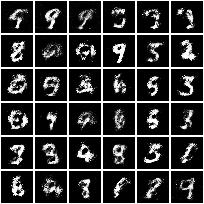

Epoch 10 out of 10 done !!!	
0.9999999993382	
-1	


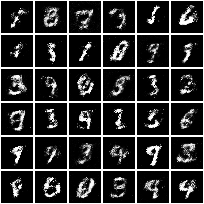

In [12]:
Plot = require 'itorch.Plot'
xaxis = {}
losses_d = {}
losses_g = {}
ii = 1

for epochId = 1, maxEpoch do
	shuffle = torch.randperm(dataSize)

	for t = 1, nBatches do
		get_real_batch(batchData, t, shuffle, batchSizeHalf)

		randomData = torch.rand(batchSizeHalf, 100)- 0.5
		randomOutput = model_g:forward(randomData)
		batchData[{{batchSizeHalf+1, batchSize},{}}]:copy( randomOutput )

		target_g:fill(1)
		target_d:narrow(1, 1, batchSizeHalf):fill(1)
		target_d:narrow(1, batchSizeHalf+1, batchSizeHalf):fill(2)
        
        table.insert(xaxis, ii)
        ii = ii + 1
		fevalg = function(x)
			output_g = model_d:forward(randomOutput)
			loss_g = criterion:forward(output_g, target_g)
			d_output_g = criterion:backward(output_g, target_g)

			d_randomOutput = model_d:backward(randomOutput, d_output_g)

			gGradParams:zero()
			model_g:backward(randomData, d_randomOutput)
		
			table.insert(losses_g, loss_g)
			return loss_g, gGradParams / batchSizeHalf
		end


		fevald = function(x)
			output_d = model_d:forward(batchData)
			loss_d = criterion:forward(output_d, target_d)
			d_output_d = criterion:backward(output_d, target_d)

			dGradParams:zero()
			model_d:backward(batchData, d_output_d)			
		
			table.insert(losses_d, loss_d)
			return loss_d, dGradParams / batchSize
		end

		optimMethod(fevalg, gParams, optimState_g)
		optimMethod(fevald, dParams, optimState_d)

	end

	print('Epoch ' .. epochId .. ' out of '..maxEpoch..' done !!!')
    randomData = torch.rand(36, 100) - 0.5
    randImgs = model_g:forward(randomData)
    randImgs = randImgs:reshape(36,1,32,32)
    print(randImgs:max())
    print(randImgs:min())
    itorch.image(randImgs)
    
--     plot = Plot():line(xaxis, losses_d, 'red', 'Loss Dis')
--     plot:line(xaxis, losses_g, 'green', 'Loss Gen'):legend(true):title('Dis and Gen Loss')
--     plot:draw():save('out.html')
end

